**IMPORT THE DIFFERENT MODELS**

In [ ]:
import tensorflow as tf ### for the
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from google.colab import drive

**GATHER AND COLLECT DATASET**

In [ ]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO* DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO* DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),list(test_dataset.take(1).as_numpy_iterator()))

dataset



[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

**DATA VISUALIZATION**

(-0.5, 129.5, 135.5, -0.5)

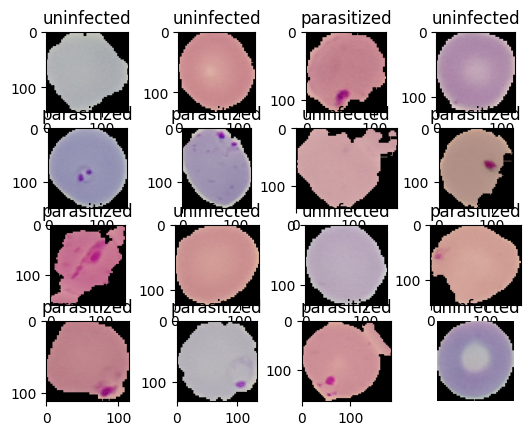

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
plt.axis('off')



In [ ]:
dataset_info.features['label'].int2str(1)


'uninfected'

**DATA REPROSESSING AND RESIZING**

In [ ]:
IM_SIZE = 224
def resize_image(image, label):
   image= tf.image.resize(image, (IM_SIZE, IM_SIZE))
   return image, label

train_dataset =  train_dataset.map(resize_image)
val_dataset =  val_dataset.map(resize_image)
test_dataset = test_dataset.map(resize_image)
train_dataset
for data in train_dataset.take(1):
  print("Input data shape:", data[0].shape)

BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset

train_dataset

Input data shape: (224, 224, 3)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**DESIGNING AND DEFINING THE MODEL**

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=6, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),



])

lenet_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 219, 219, 6)       654       
                                                                 
 batch_normalization_4 (Bat  (None, 219, 219, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 109, 109, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 107, 107, 16)      64        
 chNormalization)                                                
                                                      

**COMPLING AND TRAINING THE MODEL**

In [ ]:
y_true = [0,1,0,0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate=0.01),
                    loss = BinaryCrossentropy(),
                    metrics = 'accuracy')


In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
689/689 [==============================] - 1385s 2s/step - loss: 0.3197 - accuracy: 0.8724 - val_loss: 0.2585 - val_accuracy: 0.9187
Epoch 2/20
689/689 [==============================] - 1369s 2s/step - loss: 0.2149 - accuracy: 0.9248 - val_loss: 0.1733 - val_accuracy: 0.9405
Epoch 3/20
689/689 [==============================] - 1338s 2s/step - loss: 0.1897 - accuracy: 0.9375 - val_loss: 0.2354 - val_accuracy: 0.9328
Epoch 4/20
689/689 [==============================] - 1350s 2s/step - loss: 0.1817 - accuracy: 0.9390 - val_loss: 0.2450 - val_accuracy: 0.9296
Epoch 5/20
689/689 [==============================] - 1307s 2s/step - loss: 0.1783 - accuracy: 0.9415 - val_loss: 1.3019 - val_accuracy: 0.7956
Epoch 6/20
689/689 [==============================] - 1342s 2s/step - loss: 0.1777 - accuracy: 0.9397 - val_loss: 0.2768 - val_accuracy: 0.9241
Epoch 7/20
689/689 [==============================] - 1294s 2s/step - loss: 0.1566 - accuracy: 0.9492 - val_loss: 0.6048 - val_accuracy:

**TESTING AND EVALUATING THE MODEL**

In [ ]:
lenet_model.evaluate(test_dataset)

parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

def parasite_or_not(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')


In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" +str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')

**LOADING AND SAVING MODEL**

In [ ]:
lenet_model.save("LenetSavedModel")


lenet_model.save_weights("weights/lenet_weights")


In [ ]:
lenet_model = tf.keras.models.load_model('LenetSavedModel')
lenet_model.summary()

In [ ]:
lenet_model.save("lenet.hdf5")

In [ ]:
drive.mount('/content/drive')